# Import Libraries

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Import Data

In [212]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [213]:
movies = pd.read_csv('movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [214]:
# Filter ratings to include only the first 200 unique users
filtered_ratings_df = ratings[ratings["userId"] <= 200]

# Get the movie IDs from the filtered ratings
filtered_movie_ids = filtered_ratings_df["movieId"].unique()

# Filter the movies dataframe to include only the first 200 unique movie IDs
filtered_movies_df = movies[movies["movieId"].isin(filtered_movie_ids[:200])]

n_users = filtered_ratings_df['userId'].nunique()
print(f"Number of unique userId's: {n_users}")

n_movies = filtered_movies_df['movieId'].nunique()
print(f"Number of unique movieId's: {n_movies}")


Number of unique userId's: 200
Number of unique movieId's: 200


### Combine ratings and movies into one data frame

In [215]:
movie_data = filtered_ratings_df.merge(filtered_movies_df, on='movieId')
movie_data

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
4741,104,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
4742,129,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
4743,160,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
4744,177,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical


# EDA

In [216]:
n_ratings = len(ratings)
n_movies = movie_data['movieId'].nunique()
n_users = movie_data['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 100836
Number of unique movieId's: 200
Number of unique users: 197


### the distribution of movie ratings

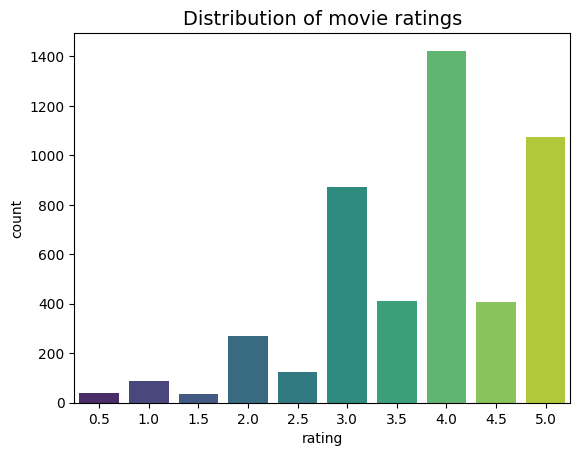

In [217]:
sns.countplot(x="rating", data=movie_data, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

### mean rating and mean rating per user

In [218]:
print(f"Mean global rating: {round(movie_data['rating'].mean(),2)}")

mean_ratings = movie_data.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}")

Mean global rating: 3.79
Mean rating per user: 3.82


### What are the lowest and highest rated movies? 

Which movie has the lowest and highest average rating?

In [219]:
mean_ratings = movie_data.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
1790,2389,Psycho (1998),Crime|Horror|Thriller


`Psycho` has the lowest average rating.

In [220]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
1332,1804,"Newton Boys, The (1998)",Crime|Drama


How many ratings does ` The Newton Boys` have?

In [221]:
movie_data[movie_data['movieId']==highest_rated]

,userId,movieId,rating,title,genres
3384,1,1804,5.0,"Newton Boys, The (1998)",Crime|Drama



`The Newton Boys` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

\begin{equation}
\text{Bayesian Average} = \frac{C \cdot m + \sum_{i=1}^{n} r_i}{C + n}
\end{equation}

Where:
* C is the weight of the prior (a constant representing the number of hypothetical observations).
* 𝑚 is the prior mean (the average rating assumed before seeing any data).
* $𝑟_𝑖$ are the actual observed ratings.
* 𝑛 is the number of actual observations.

In [222]:
def calculate_bayesian_average(df):
    # Group ratings by movieId
    movie_stats = df.groupby('movieId').agg(
        count=('rating', 'count'),
        mean=('rating', 'mean')
    )

    C = movie_stats['count'].mean()
    m = movie_stats['mean'].mean()

    # Calculate the Bayesian average for each movie
    movie_stats['bayesian_avg'] = (C * m + movie_stats['count'] * movie_stats['mean']) / (C + movie_stats['count'])

    return movie_stats.reset_index()

In [223]:
# Calculate Bayesian average
bayesian_averages = calculate_bayesian_average(movie_data)
movie_data["Bayesian_Avg"] = movie_data["movieId"].map(bayesian_averages.set_index("movieId")["bayesian_avg"])
movie_data

,userId,movieId,rating,title,genres,Bayesian_Avg
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.758559
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.758559
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.758559
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.758559
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.758559
...,...,...,...,...,...,...
4741,104,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical,3.717623
4742,129,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical,3.717623
4743,160,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical,3.717623
4744,177,3034,4.0,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical,3.717623


In [224]:
movie_data["Bayesian_Avg"].value_counts().head(10)

Bayesian_Avg
4.059819    124
3.982265    110
3.909189    107
4.039650     93
3.960519     87
4.109981     82
3.905741     81
3.694620     79
3.887608     73
3.561959     73
Name: count, dtype: int64

In [225]:
bayesian_avg_lamerica = movie_data[movie_data['movieId'] == 1804]['Bayesian_Avg'].values[0]

print(f"Bayesian_Avg of The Newton Boys is: {bayesian_avg_lamerica:.3f}")

Bayesian_Avg of The Newton Boys is: 3.722


**How many movie genres are there?**

In [226]:
from collections import Counter

movie_data['genres'] = movie_data['genres'].apply(lambda x: x.split("|"))
genre_frequency = Counter(g for genres in movie_data['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 17 genres.


Counter({'Action': 2130,
         'Comedy': 1694,
         'Adventure': 1676,
         'Thriller': 1536,
         'Drama': 1491,
         'Crime': 1156,
         'Sci-Fi': 1130,
         'Fantasy': 778,
         'Romance': 557,
         'Children': 505,
         'War': 494,
         'Mystery': 404,
         'Animation': 342,
         'Musical': 306,
         'Horror': 302,
         'Western': 168,
         'Film-Noir': 37})

In [227]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Action', 2130), ('Comedy', 1694), ('Adventure', 1676), ('Thriller', 1536), ('Drama', 1491)]


### visualize genres popularity with a barplot.

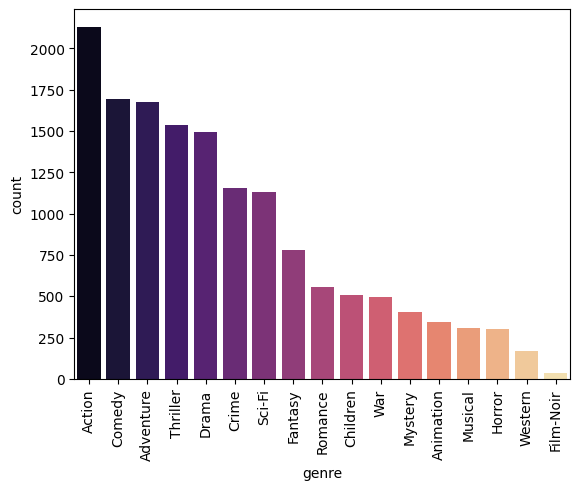

In [228]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette="magma")
plt.xticks(rotation=90)
plt.show()

# Generation of Utility Matrix

In [229]:
# Pivot the DataFrame to create the utility matrix
utility_matrix = movie_data.pivot(index='userId', columns='movieId', values='Bayesian_Avg')

utility_matrix.head()

movieId,1,3,6,47,50,70,101,110,151,157,...,2948,2949,2959,2985,2987,2991,2993,2997,3033,3034
userId,,,,,,,,,,,,,,,,,,,,,
1,3.758559,3.648486,3.790733,3.887608,4.119782,3.616016,3.73293,3.905741,3.598043,3.593277,...,3.662861,3.688884,3.941816,3.436906,3.689518,3.760818,3.695031,3.918636,3.559748,3.717623
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.887608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.941816,NaN,NaN,NaN,NaN,3.918636,3.559748,NaN
5,3.758559,NaN,NaN,NaN,4.119782,NaN,NaN,3.905741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
def calculate_sparsity(df):
    """
    Calculate the sparsity of a matrix.

    Args:
        df: pandas dataframe containing the matrix data

    Returns:
        sparsity: Sparsity of the matrix as a percentage
    """
    # Replace 0s with NaNs to treat them as missing values
    df_nan = df.replace(0, np.nan)

    # Calculate total number of possible values in the matrix
    total_values = np.prod(df.shape)

    # Calculate number of missing values in the matrix
    missing_values = df_nan.isna().sum().sum()

    # Calculate sparsity as percentage
    sparsity = round((missing_values / total_values) * 100, 2)

    return sparsity

sparsity = calculate_sparsity(utility_matrix)
print(type(utility_matrix))
print("Sparsity:", sparsity, "%")

<class 'pandas.core.frame.DataFrame'>
Sparsity: 87.95 %


In [241]:
def create_utility_matrix(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_utility_matrix(filtered_ratings_df)

In [242]:
X.shape

(200, 5596)

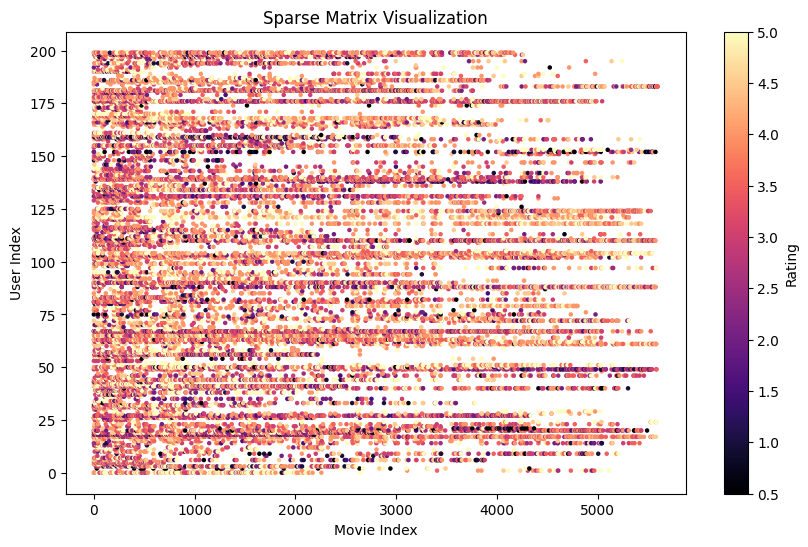

In [243]:
# Get the non-zero indices and values
non_zero_indices = X.nonzero()
non_zero_values = X.data

# Scatter plot of non-zero entries
plt.figure(figsize=(10, 6))
plt.scatter(non_zero_indices[1], non_zero_indices[0], c=non_zero_values, cmap='magma', s=5)
plt.colorbar(label='Rating')
plt.xlabel('Movie Index')
plt.ylabel('User Index')
plt.title('Sparse Matrix Visualization')
plt.show()

In [244]:
# Convert the sparse matrix to a dense 2D array
X_dense = X.toarray()

# Create a dataframe from the dense array
X_df = pd.DataFrame(X_dense)
X_df

,0,1,2,3,4,5,6,7,8,9,...,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
sparsity = calculate_sparsity(X_df)
print("Sparsity:", sparsity, "%")

Sparsity: 97.38 %


In [236]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [237]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [238]:
def find_similar_movies(movie_id, user_item_matrix, movie_name_to_id, movie_id_to_name, k, metric='cosine'):
    """
    Finds k-nearest neighbors for a given movie ID.
    
    Args:
        movie_id: ID of the movie of interest
        user_item_matrix: user-item utility matrix (rows: users, columns: movies)
        movie_name_to_id: dictionary mapping movie names to movie IDs
        movie_id_to_name: dictionary mapping movie IDs to movie names
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations (default: 'cosine')
    
    Returns: list of k similar movie titles ordered from most similar to least similar
    """
    neighbor_ids = []
    similar_movie_titles = []

    user_item_matrix = user_item_matrix.T
    
    movie_index = movie_name_to_id[movie_id]
    movie_vector = user_item_matrix[movie_index]
    if isinstance(movie_vector, (np.ndarray)):
        movie_vector = movie_vector.reshape(1, -1)
    
    # Use k+1 since kNN output includes the movie ID of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(user_item_matrix)
    distances, neighbors = kNN.kneighbors(movie_vector, return_distance=True)
    
    # Rearrange similar movies from highest similarity to lowest
    neighbors = neighbors.squeeze()
    distances = distances.squeeze()
    sorted_indices = np.argsort(distances)  # Sort indices based on distances
    sorted_neighbors = neighbors[sorted_indices]

    similarity_matrix = kNN.kneighbors_graph(user_item_matrix).toarray()
    
    for neighbor_id in sorted_neighbors[1:]:  # Skip the first neighbor (the movie itself)
        neighbor_ids.append(movie_id_to_name[neighbor_id])

    for i in neighbor_ids:
        similar_movie_titles.append(movie_titles[i])

    return similar_movie_titles, similarity_matrix

In [239]:
similar_movies, similarity_matrix = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
movie_title = movie_titles[1]

print(f"Because you watched {movie_title}:")

similar_movies

Because you watched Toy Story (1995):


['Toy Story 2 (1999)',
 'Jurassic Park (1993)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Forrest Gump (1994)',
 'Lion King, The (1994)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Mission: Impossible (1996)',
 'Groundhog Day (1993)',
 'Back to the Future (1985)']

In [240]:
similar_movies, _ = find_similar_movies(4, X, movie_mapper, movie_inv_mapper, k=10)
movie_title = movie_titles[4]

print(f"Because you watched {movie_title}:")

similar_movies

Because you watched Waiting to Exhale (1995):


['Before and After (1996)',
 'Walking Dead, The (1995)',
 'Nothing Personal (1995)',
 'Bliss (1997)',
 'Gordy (1995)',
 'Spirits of the Dead (1968)',
 'Sum of Us, The (1994)',
 'I Like It Like That (1994)',
 'Poetic Justice (1993)',
 'Georgia (1995)']